In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import

In [5]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns

# Scikit-learn
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score,fbeta_score, make_scorer

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# MLFlow
#!pip install mlflow==2.3.2
import mlflow
import mlflow.lightgbm
import mlflow.xgboost
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# increase the maximum number of columns to display
pd.set_option("display.max_columns", 1000)  # Maximum number of columns
pd.set_option("display.max_rows", 1000)  # Maximum number of columns

## Feature Engineering

In [6]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [ ]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables.
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('drive/MyDrive/Formation/Scoring/input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('drive/MyDrive/Formation/Scoring/input/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], ignore_index=True).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('drive/MyDrive/Formation/Scoring/input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('drive/MyDrive/Formation/Scoring/input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('drive/MyDrive/Formation/Scoring/input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('drive/MyDrive/Formation/Scoring/input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('drive/MyDrive/Formation/Scoring/input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('drive/MyDrive/Formation/Scoring/input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

def logistic_regression(df):
    # Divide in training/validation and test data
    # Keep only half train data due to limited ressources
    train_df = df[df['TARGET'].notnull()].sample(frac = 0.1)
    test_df = df[df['TARGET'].isnull()].sample(frac = 0.1)
    train_df['TARGET'].value_counts(dropna=False).plot.bar(title='TARGET', grid=True)
    print("Starting logistic regression. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_x, train_y = train_df[feats], train_df['TARGET']
    clf = LogisticRegression(random_state=0).fit(train_x, train_y)
    test_df['TARGET'] = clf.predict(test_df[feats])
    test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

def lightgbm(df):
    # Divide in training/validation and test data
    # Keep only half train data due to limited ressources
    train_df = df[df['TARGET'].notnull()].sample(frac = 0.1)
    test_df = df[df['TARGET'].isnull()].sample(frac = 0.1)
    train_df['TARGET'].value_counts(dropna=False).plot.bar(title='TARGET', grid=True)
    print("Starting logistic regression. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    #feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_x, train_y = train_df[feats], train_df['TARGET']
    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
    clf.fit(train_x, train_y)
    train_pred_y = clf.predict(train_x)
    test_df['TARGET'] = clf.predict(test_df[feats])
    test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    #feature_importance_df = clf.feature_importances_
    #display_importances(feature_importance_df)
    return train_y, train_pred_y

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    # Keep only half train data due to limited ressources
    train_df = df[df['TARGET'].notnull()].sample(frac = 0.01)
    test_df = df[df['TARGET'].isnull()].sample(frac = 0.05)
    train_df['TARGET'].value_counts(dropna=False).plot.bar(title='TARGET', grid=True)
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        #clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('drive/MyDrive/Formation/Scoring/output/lgbm_importances01.png')

In [ ]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
gc.collect()
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

# remove special characters in column name
df.columns=df.columns.str.replace('\W', '', regex=True)

df.to_csv("drive/MyDrive/Formation/Scoring/output/feature_engineering.csv",index=False)


Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 52s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 41s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 19s
Installments payments df shape: (339587, 26)
Process installments payments - done in 47s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 29s


## Exploration et Preprocessing

### Valeurs dupliquées

In [7]:
df = pd.read_csv("drive/MyDrive/Formation/Scoring/output/feature_engineering.csv")
df

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  \
0            0      100002     1.0            0             0   
1            1      100003     0.0            1             0   
2            2      100004     0.0            0             1   
3            3      100006     0.0            1             0   
4            4      100007     0.0            0             0   
...        ...         ...     ...          ...           ...   
356246  356250      456221     NaN            1             0   
356247  356251      456222     NaN            1             0   
356248  356252      456223     NaN            1             1   
356249  356253      456224     NaN            0             0   
356250  356254      456250     NaN            1             1   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                     0             0          202500.0    406597.5   
1                     1             0          270000.0   1293502.5   
2                     0             0           67500.0    135000.0   
3                     0             0          135000.0    312682.5   
4                     0             0          121500.0    513000.0   
...                 ...           ...               ...         ...   
356246                0             0          121500.0    412560.0   
356247                1             2          157500.0    622413.0   
356248                0             1          202500.0    315000.0   
356249                1             0          225000.0    450000.0   
356250                1             0          135000.0    312768.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0           24700.5         351000.0                    0.018801       -9461   
1           35698.5        1129500.0                    0.003541      -16765   
2            6750.0         135000.0                    0.010032      -19046   
3           29686.5         297000.0                    0.008019      -19005   
4           21865.5         513000.0                    0.028663      -19932   
...             ...              ...                         ...         ...   
356246      17473.5         270000.0                    0.002042      -19970   
356247      31909.5         495000.0                    0.035792      -11186   
356248      33205.5         315000.0                    0.026392      -15922   
356249      25128.0         450000.0                    0.018850      -13968   
356250      24709.5         270000.0                    0.006629      -13962   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0              -637.0            -3648.0            -2120          NaN   
1             -1188.0            -1186.0             -291          NaN   
2              -225.0            -4260.0            -2531         26.0   
3             -3039.0            -9833.0            -2437          NaN   
4             -3038.0            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
356246        -5169.0            -9094.0            -3399          NaN   
356247        -1149.0            -3015.0            -3003          NaN   
356248        -3037.0            -2681.0            -1504          4.0   
356249        -2731.0            -1461.0            -1364          NaN   
356250         -633.0            -1072.0            -4220         22.0   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0                1               1                0                 1   
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
356246        

In [8]:
gc.collect()

85

In [9]:
def contains_duplicates(dataframe):
    """This function checks the presence of duplicates rows in a dataframe."""

    mask = dataframe.duplicated(keep='first')
    nb_duplicates = len(dataframe[mask])

    if nb_duplicates == 0:
        return False

    else:
        return True

In [10]:
contains_duplicates(df)

False

### Valeurs manquantes

In [11]:
def global_filling_rate(dataframe):
    """Compute and displays global filling rate of a DataFrame"""

    # get the numbers of rows and columns in the dataframe
    nb_rows, nb_columns = dataframe.shape
    print("DataFrame has {} rows and {} columns.".format(nb_rows, nb_columns))

    # get the number of non-Nan data in the dataframe
    nb_data = dataframe.count().sum()

    # computing the filling rate
    filling_rate = nb_data / (nb_rows * nb_columns)
    missing_rate = 1 - filling_rate

    # computing the total missing values
    missing_values = (nb_rows * nb_columns) - nb_data

    # display global results
    print("")
    print("Global filling rate of the DataFrame: {:.2%}".format(filling_rate))
    print("Missing values in the DataFrame: {} ({:.2%})"
          .format(missing_values, missing_rate))

    # compute number of rows with missing values
    mask = dataframe.isnull().any(axis=1)
    rows_w_missing_values = len(dataframe[mask])
    rows_w_missing_values_percentage = rows_w_missing_values / nb_rows

    # display results
    print("")
    print("Number of rows with missing values: {} ({:.2%})"
          .format(rows_w_missing_values, rows_w_missing_values_percentage))

    # compute number of columns with missing values
    mask = dataframe.isnull().any(axis=0)
    cols_w_missing_values = len(dataframe[dataframe.columns[mask]].columns)
    cols_w_missing_values_percentage = cols_w_missing_values / nb_columns

    # display results
    print("Number of columns with missing values: {} ({:.2%})"
          .format(cols_w_missing_values, cols_w_missing_values_percentage))

In [12]:
gc.collect()
global_filling_rate(df)

DataFrame has 356251 rows and 798 columns.

Global filling rate of the DataFrame: 74.64%
Missing values in the DataFrame: 72099981 (25.36%)

Number of rows with missing values: 356211 (99.99%)
Number of columns with missing values: 617 (77.32%)


In [13]:
def columns_filling_rate(dataframe, columns='all', missing_only=False):
    """Calculate and displays the filling rate for
    a particular column in a pd.DataFrame."""

    # Importations
    import pandas as pd
    import numpy as np

    # If 'feature' is not specified
    if columns == 'all':
        columns = dataframe.columns


    # initialization of the results DataFrame
    results = pd.DataFrame(columns=['nb_values', 'missing_values', 'filling_rate'])

    # for each feature
    for column in columns:

        # Count of the values on each column
        values_count = dataframe[column].count()

        # Computing missing values
        nb_rows = dataframe.shape[0]
        missing_values = nb_rows - values_count

        # Computing filling rates
        filling_rate = values_count / nb_rows
        if missing_only and missing_values == 0:
            filling_rate = np.nan

        # Adding a row in the results' dataframe
        results.loc[column] = [values_count, missing_values, filling_rate]

    # Sorting the features by number of missing_values
    results = results.dropna(subset=['filling_rate'])
    results = results.sort_values('filling_rate')

    if results.empty == False:
        return results
    else:
        print("No missing value.")

In [14]:
gc.collect()
columns_filling_rate(df)

,nb_values,missing_values,filling_rate
REFUSED_RATE_DOWN_PAYMENT_MIN,52603.0,303648.0,0.147657
REFUSED_RATE_DOWN_PAYMENT_MAX,52603.0,303648.0,0.147657
REFUSED_RATE_DOWN_PAYMENT_MEAN,52603.0,303648.0,0.147657
REFUSED_AMT_DOWN_PAYMENT_MEAN,52603.0,303648.0,0.147657
REFUSED_AMT_DOWN_PAYMENT_MAX,52603.0,303648.0,0.147657
REFUSED_AMT_DOWN_PAYMENT_MIN,52603.0,303648.0,0.147657
REFUSED_APP_CREDIT_PERC_VAR,58217.0,298034.0,0.163416
CC_AMT_PAYMENT_CURRENT_VAR,71602.0,284649.0,0.200988
CC_AMT_DRAWINGS_ATM_CURRENT_VAR,71692.0,284559.0,0.201240
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,71692.0,284559.0,0.201240


In [15]:
# Dropping the columns where filling rate < 60% (except the colomn "TARGET")
# ----------------------------------------------

def get_features_under_filling_threshold(features_df, threshold=0.6):
    # computing the filling rates
    col_fillings = columns_filling_rate(features_df, columns='all', missing_only=True)

    # creating a mask for filling rate < threshold
    mask = col_fillings['filling_rate'] < threshold

    # getting the list of features
    set_cols_to_delete = set(col_fillings[mask].index)
    return set_cols_to_delete

set_cols_to_delete = {c for c in get_features_under_filling_threshold(df) if c != 'TARGET'}

# deleting the rows
df = df.drop(columns=set_cols_to_delete)

global_filling_rate(df)
print(df.shape)

DataFrame has 356251 rows and 553 columns.

Global filling rate of the DataFrame: 93.88%
Missing values in the DataFrame: 12057090 (6.12%)

Number of rows with missing values: 277191 (77.81%)
Number of columns with missing values: 372 (67.27%)
(356251, 553)


In [16]:
gc.collect()
columns_filling_rate(df, columns='all', missing_only=True)

,nb_values,missing_values,filling_rate
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,218100.0,138151.0,0.612209
CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,229937.0,126314.0,0.645435
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,239860.0,116391.0,0.673289
ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,239860.0,116391.0,0.673289
ACTIVE_DAYS_CREDIT_ENDDATE_MIN,241342.0,114909.0,0.677449
ACTIVE_DAYS_CREDIT_ENDDATE_MAX,241342.0,114909.0,0.677449
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,241342.0,114909.0,0.677449
APPROVED_APP_CREDIT_PERC_VAR,249103.0,107148.0,0.699235
ACTIVE_AMT_CREDIT_SUM_MEAN,251808.0,104443.0,0.706827
ACTIVE_AMT_CREDIT_SUM_MAX,251808.0,104443.0,0.706827


### Typage des données

In [17]:
df.describe()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Baddebt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_ACTIVE_nan_MEAN,BURO_CREDIT_CURRENCY_currency1_MEAN,BURO_CREDIT_CURRENCY_currency2_MEAN,BURO_CREDIT_CURRENCY_currency3_MEAN,BURO_CREDIT_CURRENCY_currency4_MEAN,BURO_CREDIT_CURRENCY_nan_MEAN,BURO_CREDIT_TYPE_Anothertypeofloan_MEAN,BURO_CREDIT_TYPE_Carloan_MEAN,BURO_CREDIT_TYPE_Cashloannonearmarked_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,BURO_CREDIT_TYPE_Interbankcredit_MEAN,BURO_CREDIT_TYPE_Loanforbusinessdevelopment_MEAN,BURO_CREDIT_TYPE_Loanforpurchaseofsharesmarginlending_MEAN,BURO_CREDIT_TYPE_Loanforthepurchaseofequipment_MEAN,BURO_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobileoperatorloan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Realestateloan_MEAN,BURO_CREDIT_TYPE_Unknowntypeofloan_MEAN,BURO_CREDIT_TYPE_nan_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,ACTIVE_CNT_CREDIT_PROLONG_SUM,ACTIVE_MONTHS_BALANCE_SIZE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_SIZE_SUM,PREV_AM

In [18]:
df.dtypes

index                                                                int64
SK_ID_CURR                                                           int64
TARGET                                                             float64
CODE_GENDER                                                          int64
FLAG_OWN_CAR                                                         int64
FLAG_OWN_REALTY                                                      int64
CNT_CHILDREN                                                         int64
AMT_INCOME_TOTAL                                                   float64
AMT_CREDIT                                                         float64
AMT_ANNUITY                                                        float64
AMT_GOODS_PRICE                                                    float64
REGION_POPULATION_RELATIVE                                         float64
DAYS_BIRTH                                                           int64
DAYS_EMPLOYED            

### Keep only data with Target values

In [19]:
# Divide in training/validation and test data
# Keep only a part of train data due to limited ressources
train_df = df[df['TARGET'].notnull()].sample(10000)
test_df = df[df['TARGET'].isnull()].sample(2000)
print(train_df.shape, test_df.shape)

(10000, 553) (2000, 553)


In [20]:
gc.collect()

0

### Séparation des données d'entraînement (*X_train*) et de validation (X_eval)


In [21]:
y=train_df['TARGET']
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X=train_df.filter(feats)
# Sépration en jeu d'entrainement / jeu de validation, 80% des données pour l'entraînement
X_train, X_eval, y_train, y_eval = model_selection.train_test_split(X, y, train_size=0.8)

# vérification de la taille des données :
X_train.shape, X_eval.shape

((8000, 550), (2000, 550))

### Imputations

In [22]:
from sklearn.impute import SimpleImputer

# Imputation des valeurs manquantes
def imputation(X_train_, X_eval_) :
    X_train_.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_eval_.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Taux de valeurs manquantes :
    print("Taux de valeurs manquantes dans jeu de train avant imputatation :" , round(X_train_.isna().mean().mean(),4))
    print("Taux de valeurs manquantes dans jeu de test avant imputatation :" , round(X_eval_.isna().mean().mean(),4))

    # Imputation des valeurs manquantes
    imp_mean = SimpleImputer(strategy='mean')
    imp_mean.fit(X_train_)
    X_train_imputed = pd.DataFrame(imp_mean.transform(X_train_), columns=X_train_.columns, index=X_train_.index)
    X_eval_imputed = pd.DataFrame(imp_mean.transform(X_eval_), columns=X_eval_.columns, index=X_eval_.index)

    # Taux de valeurs manquantes :
    print("Taux de valeurs manquantes après imputatation - jeu de train:" , round(X_train_imputed.isna().mean().mean(),4))
    print("Taux de valeurs manquantes après imputatation - jeu de test:" , round(X_eval_imputed.isna().mean().mean(),4))

    return X_train_imputed, X_eval_imputed


In [23]:
X_train_imputed, X_eval_imputed = imputation(X_train, X_eval)
print(X_train_imputed.shape, X_eval_imputed.shape)

Taux de valeurs manquantes dans jeu de train avant imputatation : 0.0619
Taux de valeurs manquantes dans jeu de test avant imputatation : 0.0625
Taux de valeurs manquantes après imputatation - jeu de train: 0.0
Taux de valeurs manquantes après imputatation - jeu de test: 0.0
(8000, 550) (2000, 550)


In [24]:
X_train_imputed.to_csv("drive/MyDrive/Formation/Scoring/output/X_train_imputed.csv",index=False)
X_eval_imputed.to_csv("drive/MyDrive/Formation/Scoring/output/X_eval_imputed.csv",index=False)

### Équilibre des classes

In [25]:
X_train_imputed = pd.read_csv("drive/MyDrive/Formation/Scoring/output/X_train_imputed.csv")
X_eval_imputed = pd.read_csv("drive/MyDrive/Formation/Scoring/output/X_eval_imputed.csv")

In [26]:
def categorical_distribution(column, ordinal=False):
    """Function plotting the bar-plot and pie-plot (as subplots) for
    a distribution of categorical features."""

    # importing libraries
    import matplotlib.pyplot as plt

    # Set frequencies and labels, sorting by index
    labels = list(column.value_counts().sort_values(ascending=False).index.astype(str))
    frequencies = column.value_counts().sort_values(ascending=False)

    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))

    plt.suptitle("Distribution", fontsize=25)


    # plotting the plots
    plt.pie(frequencies,
            autopct='%1.2f%%',
            shadow=True)

    plt.legend(labels)
    plt.show()
    return fig

In [27]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from imblearn.over_sampling import SMOTE
def balance_data(X_train_imputed, y_train):
    fig_before = categorical_distribution(y_train, 'TARGET')
    print(y_train.value_counts())

    oversample = SMOTE()
    X_train_balanced, y_train_balanced = oversample.fit_resample(X_train_imputed, y_train)

    fig_after = categorical_distribution(y_train_balanced, 'TARGET')
    print(y_train_balanced.value_counts())
    return X_train_balanced, y_train_balanced

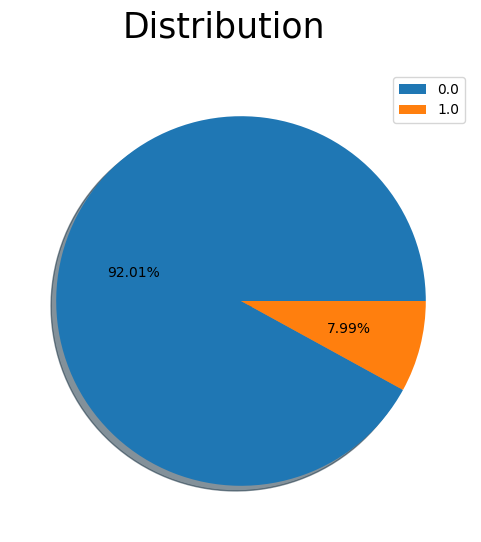

TARGET
0.0    7361
1.0     639
Name: count, dtype: int64


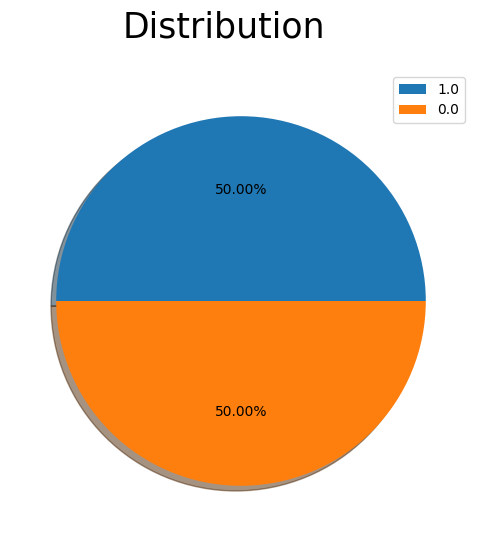

TARGET
1.0    7361
0.0    7361
Name: count, dtype: int64


In [28]:
X_train_balanced, y_train_balanced = balance_data(X_train_imputed, y_train)

## Modélisation

### Custom scoring function

les datasets sont déséquilibrés au niveau des classes

créer matrice de confusion (2x2)

faux positif (y_pred = 1, y_true= 0) n'a pas le même d'impacte que faux négatif (y_pred = 0, y_true= 1) (10 fois plus couteux)

f1_score ne permet pas de prende en compte de ça

création d'un score métier avec make_scorer
fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    custom_score = fp * 10 + fn

Fonction cout métier:

fp = np.sum((y_pred == 0) & (y_true == 1))

fn = np.sum((y_pred == 1) & (y_true == 0))

custom_score = fp * 10 + fn

In [29]:
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, roc_auc_score

def find_best_threshold(y, y_pred_prob):

    scores = np.array([])

    for threshold in np.arange(0, 1, 0.01):

        y_pred = y_pred_prob > threshold

        mat_conf = confusion_matrix(y, y_pred)

        tn = mat_conf[0, 0]
        fn = mat_conf[1, 0]
        fp = mat_conf[0, 1]
        tp = mat_conf[1, 1]

        score = 1*fp + 10*fn

        scores = np.append(scores, score)
        # print(y_pred_prob)
        print("threshold: " + str(threshold) + ", score: " + str(score))

    best_score = scores.min()
    best_threshold = np.arange(0, 1, 0.01)[scores.argmin()]
    print("best_threshold: " + str(best_threshold) + ", best_score: " + str(best_score))
    print('---------------------------------------------------------------------------------------')
    return best_score, best_threshold


def score_metier(y, y_pred_prob):
    best_score, best_threshold = find_best_threshold(y, y_pred_prob)
    return best_score

def seuil_metier(y, y_pred_prob):
    best_score, best_threshold = find_best_threshold(y, y_pred_prob)
    return best_threshold

scoring = {
    "Score metier": make_scorer(score_metier, needs_proba=True, greater_is_better = False),
    "Seuil metier": make_scorer(seuil_metier, needs_proba=True, greater_is_better = False),
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score)
}



### MLFlow

In [30]:
##########################
# FONCTIONS MLFlow       #
#########################
# ML FLOW
def fetch_logged_data(run_id):
    client = MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

# enable autologging
mlflow.set_experiment("Scoring")
mlflow.sklearn.autolog()

### Comparaison des modèles

#### Grid Search Cross Validation avec Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


dt_pipe = Pipeline([('scaler',  StandardScaler()),
          ('model', DecisionTreeClassifier(random_state = 42))])

dt_grid_params = [{
  'model__min_samples_split' : [10,100],}]

dt_grid_search = GridSearchCV(
    estimator = dt_pipe,
    param_grid=dt_grid_params,
    scoring=scoring,
    refit="Score metier",
    cv=4,
)

In [32]:
with timer("DecisionTree Grid Search Cross Validation"):
    with mlflow.start_run() as run:
        dt_grid_search.fit(X_train_balanced, y_train_balanced)

threshold: 0.0, score: 5467
threshold: 0.01, score: 5467
threshold: 0.02, score: 5467
threshold: 0.03, score: 5467
threshold: 0.04, score: 5467
threshold: 0.05, score: 5467
threshold: 0.06, score: 5467
threshold: 0.07, score: 5467
threshold: 0.08, score: 5467
threshold: 0.09, score: 5467
threshold: 0.1, score: 5467
threshold: 0.11, score: 5467
threshold: 0.12, score: 5487
threshold: 0.13, score: 5486
threshold: 0.14, score: 5486
threshold: 0.15, score: 5486
threshold: 0.16, score: 5486
threshold: 0.17, score: 5513
threshold: 0.18, score: 5513
threshold: 0.19, score: 5513
threshold: 0.2, score: 5569
threshold: 0.21, score: 5569
threshold: 0.22, score: 5569
threshold: 0.23, score: 5569
threshold: 0.24, score: 5569
threshold: 0.25, score: 5576
threshold: 0.26, score: 5576
threshold: 0.27, score: 5576
threshold: 0.28, score: 5576
threshold: 0.29, score: 5576
threshold: 0.3, score: 5576
threshold: 0.31, score: 5576
threshold: 0.32, score: 5576
threshold: 0.33, score: 5576
threshold: 0.34, s

2024/05/19 21:52:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/05/19 21:52:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/sklearn/utils.py:784: UserWarning: Top 5 child runs will be created based on ordering in rank_test_Score metier column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2024/05/19 21:52:18 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


DecisionTree Grid Search Cross Validation - done in 58s


In [33]:
# fetch logged data
params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

print(params)
print(metrics)
print(tags)
print(artifacts)

{'n_jobs': 'None', 'refit': 'Score metier', 'best_model__min_samples_split': '100', 'error_score': 'nan', 'verbose': '0', 'cv': '4', 'estimator': "Pipeline(steps=[('scaler', StandardScaler()),\n                ('model', DecisionTreeClassifier(random_state=42))])", 'pre_dispatch': '2*n_jobs', 'param_grid': "[{'model__min_samples_split': [10, 100]}]", 'scoring': "{'Score metier': make_scorer(score_metier, greater_is_better=False, needs_proba=True), 'Seuil metier': make_scorer(seuil_metier, greater_is_better=False, needs_proba=True), 'accuracy': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score)}", 'return_train_score': 'False'}
{'training_recall_score': 0.9396141828555903, 'training_f1_score': 0.9395915440333935, 'training_precision_score': 0.9402741758068707, 'training_accuracy_score': 0.9396141828555903, 'best_cv_score': -1501.5, 'training_roc_auc': 0.9891953891975502, 'training_score': -2024.0, 'training_log_loss': 0.12427770568527882}
{'estimator_class': 'sklearn.mode

In [34]:
  seuils_metiers_pour_tous_les_modeles_dt = dt_grid_search.cv_results_['mean_test_Seuil metier']
  seuil_metier_best_model = seuils_metiers_pour_tous_les_modeles_dt[dt_grid_search.best_index_]

  print(dt_grid_search.cv_results_)
  print("Seuil moyen pour le Best Model :" , -seuil_metier_best_model)
  print("Score métier correspondant :" , -dt_grid_search.best_score_)

{'mean_fit_time': array([3.76495397, 3.26908445]), 'std_fit_time': array([0.79756351, 0.22960281]), 'mean_score_time': array([1.18992102, 1.27485383]), 'std_score_time': array([0.28780661, 0.29226907]), 'param_model__min_samples_split': masked_array(data=[10, 100],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'model__min_samples_split': 10}, {'model__min_samples_split': 100}], 'split0_test_Score metier': array([-5467., -3484.]), 'split1_test_Score metier': array([-657., -910.]), 'split2_test_Score metier': array([-646., -799.]), 'split3_test_Score metier': array([-772., -813.]), 'mean_test_Score metier': array([-1885.5, -1501.5]), 'std_test_Score metier': array([2068.3687413 , 1145.39480093]), 'rank_test_Score metier': array([2, 1], dtype=int32), 'split0_test_Seuil metier': array([-0., -0.]), 'split1_test_Seuil metier': array([-0.34, -0.17]), 'split2_test_Seuil metier': array([-0.13, -0.2 ]), 'split3_test_Seuil metier': array([-0.25, -

In [35]:
print(dt_grid_search.best_score_, dt_grid_search.best_params_) # Affichez le meilleur score  et les meilleurs hyperparamètres.
dt_grid_search.best_estimator_.score(X_eval_imputed, y_eval) # prédiction sur la base de test avec à partir du modèle entraîné

-1501.5 {'model__min_samples_split': 100}


0.852

In [36]:
dt_grid_results = pd.DataFrame(dt_grid_search.cv_results_)
dt_grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__min_samples_split,params,split0_test_Score metier,split1_test_Score metier,split2_test_Score metier,split3_test_Score metier,mean_test_Score metier,std_test_Score metier,rank_test_Score metier,split0_test_Seuil metier,split1_test_Seuil metier,split2_test_Seuil metier,split3_test_Seuil metier,mean_test_Seuil metier,std_test_Seuil metier,rank_test_Seuil metier,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,3.764954,0.797564,1.189921,0.287807,10,{'model__min_samples_split': 10},-5467.0,-657.0,-646.0,-772.0,-1885.5,2068.368741,2,-0.0,-0.34,-0.13,-0.25,-0.1800,0.127867,2,0.829123,0.932627,0.929891,0.923913,0.903888,0.043281,1,0.829160,0.932639,0.929891,0.923913,0.903901,0.043267,1
1,3.269084,0.229603,1.274854,0.292269,100,{'model__min_samples_split': 100},-3484.0,-910.0,-799.0,-813.0,-1501.5,1145.394801,1,-0.0,-0.17,-0.20,-0.22,-0.1475,0.086999,1,0.816626,0.909807,0.920652,0.921467,0.892138,0.043839,2,0.816663,0.909814,0.920652,0.921467,0.892149,0.043824,2


In [37]:
 output_dt = {
     'Accuracy': accuracy_score(y_eval, dt_grid_search.predict(X_eval_imputed)),
     'AUC': roc_auc_score(y_eval, dt_grid_search.predict_proba(X_eval_imputed)[:,1]),
     'fbeta_score': fbeta_score(y_eval, dt_grid_search.predict(X_eval_imputed), beta=2),
     'mean fit time' : dt_grid_results.loc[dt_grid_results['rank_test_accuracy']==1,'mean_fit_time'].values[0]

 }
output_dt

{'Accuracy': 0.852,
 'AUC': 0.5718036036036036,
 'fbeta_score': 0.11508951406649613,
 'mean fit time': 3.7649539709091187}

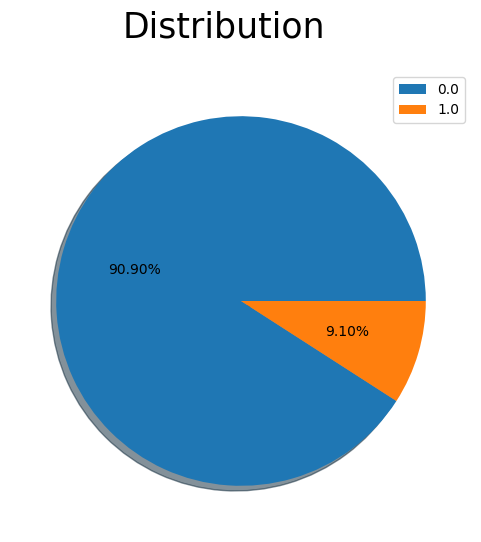

In [38]:
y_predict = dt_grid_search.predict(X_eval_imputed)
y_predict_proba = dt_grid_search.predict_proba(X_eval_imputed)[:,1]
fig_y_predict = categorical_distribution(pd.Series(y_predict), 'TARGET')

#### Grid Search Cross Validation avec LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


lgbm_pipe = Pipeline([('scaler',  StandardScaler()),
          ('model', LGBMClassifier(random_state = 42))])

# Paramètres de la grille de recherche
lgbm_grid_params = { 'model__n_estimators': [200, 500,1000],
                        'model__learning_rate': [0.02,0.1,0.5],
                        'model__max_depth' : [3,5,8],
                       }
# Initialisation de la grille de recherhce
lgbm_grid_search = GridSearchCV(
    estimator = lgbm_pipe,
    param_grid=lgbm_grid_params,
    scoring=scoring,
    refit="Score metier",
    cv=4,
    # n_jobs=10,
    # verbose=True
)

# enable autologging
#mlflow.set_experiment("Scoring")
#mlflow.lightgbm.autolog()


In [ ]:
with timer(" LightGBM Grid Search Cross Validation"):
    with mlflow.start_run() as run:
        lgbm_grid_search.fit(X_train_balanced, y_train_balanced)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive g

2024/05/16 21:33:47 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-04-18; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'rmm-cu12'}
2024/05/16 21:33:51 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-04-18; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'rmm-cu12'}
2024/05/16 21:33:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/sklearn/utils.py:784: UserWarning: Top 5 child runs will be created based on ordering in rank_test_Score metier column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2024/05/16 21:33:51 INFO mlflow.sklearn.utils: Logging the 5 best runs

 LightGBM Grid Search Cross Validation - done in 2562s


In [ ]:
# fetch logged data
params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

print(params)
print(metrics)
print(tags)
print(artifacts)

In [ ]:
  seuils_metiers_pour_tous_les_modeles_lgbm = lgbm_grid_search.cv_results_['mean_test_Seuil metier']
  seuil_metier_best_model_lgbm = seuils_metiers_pour_tous_les_modeles_lgbm[lgbm_grid_search.best_index_]

  print(lgbm_grid_search.cv_results_)
  print("Seuil moyen pour le Best Model :" , -seuil_metier_best_model_lgbm)
  print("Score métier correspondant :" , -lgbm_grid_search.best_score_)

{'mean_fit_time': array([ 6.08238059, 11.53157282, 21.52663976, 12.67221773, 26.51369798,
       44.10917562, 16.98292518, 36.71202385, 69.90994799,  5.50156987,
       11.26464546, 20.02187294,  9.97115695, 20.68734807, 35.84682351,
       14.68411565, 29.88599628, 55.53925556,  5.51391298,  9.97658753,
       18.0627113 ,  8.92754543, 17.16725492, 23.74674606, 13.02424002,
       18.39697623, 25.19545197]), 'std_fit_time': array([ 0.87963388,  0.40631025,  0.84161827,  1.26052075,  2.49665308,
        2.8463787 ,  0.3628335 ,  0.82935994,  3.01577908,  0.53088554,
        0.83553727,  0.69756302,  0.80760438,  1.14157048,  6.27140061,
        0.43662012,  5.54572651, 16.17065133,  0.90013712,  0.79969138,
        2.9632081 ,  1.02697749,  4.59381636,  5.90088252,  3.42267936,
        4.78762913,  6.56307509]), 'mean_score_time': array([1.44760936, 1.58504254, 1.75310856, 1.18557084, 1.49946654,
       1.69610447, 1.3974179 , 1.76343948, 2.47249597, 1.29385036,
       1.4384343 , 1.67

In [ ]:
print(lgbm_grid_search.best_score_, lgbm_grid_search.best_params_) # Affichez le meilleur score  et les meilleurs hyperparamètres.
lgbm_grid_search.best_estimator_.score(X_test, y_test) # prédiction sur la base de test avec à partir du modèle entraîné

-432.0 {'model__learning_rate': 0.02, 'model__max_depth': 5, 'model__n_estimators': 200}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.9479705802233723

In [ ]:
lgbm_grid_results = pd.DataFrame(lgbm_grid_search.cv_results_)
lgbm_grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,params,split0_test_Score metier,split1_test_Score metier,split2_test_Score metier,split3_test_Score metier,mean_test_Score metier,std_test_Score metier,rank_test_Score metier,split0_test_Seuil metier,split1_test_Seuil metier,split2_test_Seuil metier,split3_test_Seuil metier,mean_test_Seuil metier,std_test_Seuil metier,rank_test_Seuil metier,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,6.082381,0.879634,1.447609,0.301915,0.02,3,200,"{'model__learning_rate': 0.02, 'model__max_dep...",-1767.0,-62.0,-46.0,-54.0,-482.25,741.772329,27,-0.07,-0.46,-0.50,-0.45,-0.3700,0.174213,2,0.819717,0.994281,0.994824,0.995369,0.951048,0.075825,17,0.819717,0.994281,0.994825,0.995369,0.951048,0.075825,17
1,11.531573,0.406310,1.585043,0.243662,0.02,3,500,"{'model__learning_rate': 0.02, 'model__max_dep...",-1836.0,-22.0,-2.0,-13.0,-468.25,789.702594,25,-0.00,-0.46,-0.59,-0.54,-0.3975,0.234134,4,0.820806,0.998366,0.997548,0.997276,0.953499,0.076611,2,0.820806,0.998366,0.997549,0.997275,0.953499,0.076611,2
2,21.526640,0.841618,1.753109,0.389470,0.02,3,1000,"{'model__learning_rate': 0.02, 'model__max_dep...",-1836.0,-10.0,-2.0,-13.0,-465.25,791.413095,22,-0.00,-0.50,-0.64,-0.65,-0.4475,0.265083,6,0.821078,0.997277,0.993462,0.995369,0.951797,0.075482,12,0.821078,0.997277,0.993464,0.995368,0.951797,0.075482,12
3,12.672218,1.260521,1.185571,0.056487,0.02,5,200,"{'model__learning_rate': 0.02, 'model__max_dep...",-1679.0,-29.0,-9.0,-11.0,-432.00,719.997917,1,-0.03,-0.46,-0.48,-0.55,-0.3800,0.204817,3,0.820806,0.998638,0.997821,0.999183,0.954112,0.076966,1,0.820806,0.998638,0.997821,0.999183,0.954112,0.076966,1
4,26.513698,2.496653,1.499467,0.234580,0.02,5,500,"{'model__learning_rate': 0.02, 'model__max_dep...",-1836.0,-5.0,-0.0,-4.0,-461.25,793.714487,7,-0.00,-0.54,-0.69,-0.57,-0.4500,0.265801,7,0.821078,0.998094,0.995642,0.997821,0.953159,0.076262,4,0.821078,0.998094,0.995643,0.997820,0.953159,0.076263,4
5,44.109176,2.846379,1.696104,0.045730,0.02,5,1000,"{'model__learning_rate': 0.02, 'model__max_dep...",-1836.0,-10.0,-0.0,-3.0,-462.25,793.143233,13,-0.00,-0.55,-0.80,-0.64,-0.4975,0.300863,9,0.821078,0.995643,0.995097,0.995914,0.951933,0.075549,11,0.821078,0.995643,0.995098,0.995913,0.951933,0.075549,11
6,16.982925,0.362833,1.397418,0.248899,0.02,8,200,"{'model__learning_rate': 0.02, 'model__max_dep...",-1704.0,-24.0,-4.0,-25.0,-439.25,730.251797,2,-0.02,-0.42,-0.55,-0.41,-0.3500,0.198368,1,0.821078,0.997821,0.996186,0.997821,0.953227,0.076299,3,0.821078,0.997821,0.996187,0.997821,0.953227,0.076299,3
7,36.712024,0.829360,1.763439,0.349610,0.02,8,500,"{'model__learning_rate': 0.02, 'model__max_dep...",-1836.0,-6.0,-0.0,-2.0,-461.00,793.859559,4,-0.00,-0.58,-0.75,-0.64,-0.4925,0.290807,8,0.821078,0.997004,0.995914,0.997821,0.952954,0.076142,5,0.821078,0.997004,0.995915,0.997820,0.952954,0.076142,5
8,69.909948,3.015779,2.472496,0.479983,0.02,8,1000,"{'model__learning_rate': 0.02, 'model__max_dep...",-1836.0,-1.0,-0.0,-0.0,-459.25,794.867088,3,-0.00,-0.65,-0.82,-0.70,-0.5425,0.319247,12,0.821078,0.995915,0.996186,0.997548,0.952682,0.075984,7,0.821078,0.995915,0.996187,0.997548,0.952682,0.075984,7
9,5.501570,0.530886,1.293850,0.277678,0.1,3,200,"{'model__learning_rate': 0.1, 'model__max_dept...",-1836.0,-10.0,-4.0,-7.0,-464.25,791.983073,20,-0.00,-0.54,-0.65,-0.57,-0.4400,0.257196,5,0.821078,0.995643,0.993190,0.995642,0.951388,0.075241,14,0.821078,0.995643,0.993192,0.995640,0.951388,0.075241,14


In [ ]:
 lgbm_output = {
     'Accuracy': accuracy_score(y_eval, lgbm_grid_search.predict(X_eval_imputed)),
     'AUC': roc_auc_score(y_eval, lgbm_grid_search.predict_proba(X_eval_imputed)[:,1]),
     'fbeta_score': fbeta_score(y_eval, lgbm_grid_search.predict(X_eval_imputed), beta=2),
     'mean fit time' : lgbm_grid_results.loc[lgbm_grid_results['rank_test_accuracy']==1,'mean_fit_time'].values[0]

 }
lgbm_output

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


{'Accuracy': 0.927,
 'AUC': 0.7391201548669297,
 'fbeta_score': 0.0,
 'mean fit time': 12.672217726707458}

#### Grid Search Cross Validation avec XGBOOST

---



In [28]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


xgboost_pipe = Pipeline([('scaler',  StandardScaler()),
          ('model', XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42))])

# Paramètres de la grille de recherche
xgboost_grid_params = {'model__learning_rate': [0.5],
                            'model__max_depth': [3, 5, 8],
                           'model__n_estimators': [200,500,1000]
                          }
# Initialisation de la grille de recherhce
xgboost_grid_search = GridSearchCV(
    estimator = xgboost_pipe,
    param_grid=xgboost_grid_params,
    scoring=scoring,
    refit="Score metier",
    cv=4,
    # n_jobs=10,
    # verbose=True
)

# enable autologging
#mlflow.set_experiment("Scoring")
#mlflow.lightgbm.autolog()


In [ ]:
with timer(" LightGBM Grid Search Cross Validation"):
    with mlflow.start_run() as run:
        xgboost_grid_search.fit(X_train_balanced, y_train_balanced)

2024/05/17 02:13:42 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_...`


Streaming output truncated to the last 5000 lines.
best_threshold: 0.9500000000000001, best_score: 6.0
---------------------------------------------------------------------------------------
threshold: 0.0, score: 1836
threshold: 0.01, score: 5980
threshold: 0.02, score: 6155
threshold: 0.03, score: 6263
threshold: 0.04, score: 6293
threshold: 0.05, score: 6312
threshold: 0.06, score: 6331
threshold: 0.07, score: 6340
threshold: 0.08, score: 6370
threshold: 0.09, score: 6370
threshold: 0.1, score: 6380
threshold: 0.11, score: 6390
threshold: 0.12, score: 6410
threshold: 0.13, score: 6410
threshold: 0.14, score: 6430
threshold: 0.15, score: 6430
threshold: 0.16, score: 6450
threshold: 0.17, score: 6460
threshold: 0.18, score: 6480
threshold: 0.19, score: 6490
threshold: 0.2, score: 6490
threshold: 0.21, score: 6490
threshold: 0.22, score: 6500
threshold: 0.23, score: 6500
threshold: 0.24, score: 6500
threshold: 0.25, score: 6500
threshold: 0.26, score: 6500
threshold: 0.27, score: 6510


2024/05/17 03:31:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/sklearn/utils.py:784: UserWarning: Top 5 child runs will be created based on ordering in rank_test_Score metier column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2024/05/17 03:31:33 INFO mlflow.sklearn.utils: Logging the 5 best runs, 22 runs will be omitted.
2024/05/17 03:31:33 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('scaler', StandardScaler()), ('model', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learni

 LightGBM Grid Search Cross Validation - done in 4671s


In [ ]:
# fetch logged data
params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

print(params)
print(metrics)
print(tags)
print(artifacts)

{'verbose': '0', 'return_train_score': 'False', 'best_model__learning_rate': '0.01', 'scoring': "{'Score metier': make_scorer(score_metier, greater_is_better=False, needs_proba=True), 'Seuil metier': make_scorer(seuil_metier, greater_is_better=False, needs_proba=True), 'accuracy': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score)}", 'best_model__n_estimators': '500', 'param_grid': "{'model__learning_rate': [0.01, 0.1, 0.5], 'model__max_depth': [3, 5, 8], 'model__n_estimators': [200, 500, 1000]}", 'n_jobs': 'None', 'cv': '4', 'refit': 'Score metier', 'estimator': "Pipeline(steps=[('scaler', StandardScaler()),\n                ('model',\n                 XGBClassifier(base_score=None, booster=None, callbacks=None,\n                               colsample_bylevel=None, colsample_bynode=None,\n                               colsample_bytree=None, device=None,\n                               early_stopping_rounds=None,\n                               enable_categorical=Fal

In [ ]:
  seuils_metiers_pour_tous_les_modeles_xgboost = xgboost_grid_search.cv_results_['mean_test_Seuil metier']
  seuil_metier_best_model_xgboost = seuils_metiers_pour_tous_les_modeles_xgboost[xgboost_grid_search.best_index_]

  print(xgboost_grid_search.cv_results_)
  print("Seuil moyen pour le Best Model :" , -seuil_metier_best_model_xgboost)
  print("Score métier correspondant :" , -xgboost_grid_search.best_score_)

{'mean_fit_time': array([  9.16842645,  21.11619383,  40.29317522,  18.86881196,
        43.5908376 ,  88.78756475,  53.0608567 , 111.23839062,
       179.11143118,   8.87957972,  17.99529493,  33.73316658,
        14.94400704,  30.97478998,  55.64171958,  30.24434644,
        49.58762717,  72.74453211,   7.77423477,  17.74875224,
        34.32630503,  12.11256438,  24.69525415,  39.907085  ,
        15.84892869,  25.90211821,  39.80228746]), 'std_fit_time': array([ 0.99474955,  0.70747   ,  0.74875542,  0.4030098 ,  1.75563462,
       17.10772551,  1.6505448 , 12.18730665, 24.49002178,  0.93371209,
        0.21694737,  0.75280129,  0.79169425,  4.50665952,  9.02567994,
        4.85472248, 12.04806243, 17.75045158,  0.98196347,  1.88512194,
        4.69270542,  2.56927392,  5.36758425,  7.23533523,  3.35464904,
        5.78258822,  7.16349499]), 'mean_score_time': array([1.2052471 , 1.3622719 , 1.32771188, 1.25509787, 1.40280843,
       1.57149297, 1.44534808, 1.37618524, 1.73382157, 1

In [ ]:
print(xgboost_grid_search.best_score_, xgboost_grid_search.best_params_) # Affichez le meilleur score  et les meilleurs hyperparamètres.
xgboost_grid_search.best_estimator_.score(X_test, y_test) # prédiction sur la base de test avec à partir du modèle entraîné

-391.25 {'model__learning_rate': 0.01, 'model__max_depth': 8, 'model__n_estimators': 500}


0.9406156360664669

In [ ]:
xgboost_grid_results = pd.DataFrame(xgboost_grid_search.cv_results_)
xgboost_grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,params,split0_test_Score metier,split1_test_Score metier,split2_test_Score metier,split3_test_Score metier,mean_test_Score metier,std_test_Score metier,rank_test_Score metier,split0_test_Seuil metier,split1_test_Seuil metier,split2_test_Seuil metier,split3_test_Seuil metier,mean_test_Seuil metier,std_test_Seuil metier,rank_test_Seuil metier,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,9.168426,0.994750,1.205247,0.278304,0.01,3,200,"{'model__learning_rate': 0.01, 'model__max_dep...",-1771.0,-349.0,-333.0,-295.0,-687.00,626.154933,27,-0.13,-0.42,-0.45,-0.42,-0.3550,0.130480,4,0.812364,0.978486,0.979842,0.980387,0.937770,0.072406,27,0.812364,0.978486,0.979842,0.980388,0.937770,0.072407,27
1,21.116194,0.707470,1.362272,0.265288,0.01,3,500,"{'model__learning_rate': 0.01, 'model__max_dep...",-1783.0,-122.0,-144.0,-116.0,-541.25,717.000479,26,-0.04,-0.47,-0.49,-0.47,-0.3675,0.189258,5,0.817810,0.994826,0.992645,0.994007,0.949822,0.076221,15,0.817810,0.994826,0.992645,0.994008,0.949822,0.076221,15
2,40.293175,0.748755,1.327712,0.302344,0.01,3,1000,"{'model__learning_rate': 0.01, 'model__max_dep...",-1787.0,-94.0,-84.0,-73.0,-509.50,737.602366,23,-0.01,-0.46,-0.56,-0.55,-0.3950,0.225666,8,0.818900,0.996187,0.994552,0.995914,0.951388,0.076495,8,0.818900,0.996187,0.994552,0.995914,0.951388,0.076495,8
3,18.868812,0.403010,1.255098,0.298724,0.01,5,200,"{'model__learning_rate': 0.01, 'model__max_dep...",-1674.0,-160.0,-156.0,-142.0,-533.00,658.790559,25,-0.10,-0.40,-0.44,-0.40,-0.3350,0.136657,2,0.815904,0.993464,0.993735,0.994279,0.949346,0.077043,17,0.815904,0.993464,0.993734,0.994281,0.949346,0.077043,17
4,43.590838,1.755635,1.402808,0.276655,0.01,5,500,"{'model__learning_rate': 0.01, 'model__max_dep...",-1668.0,-84.0,-68.0,-73.0,-473.25,689.813516,18,-0.02,-0.41,-0.47,-0.42,-0.3300,0.180416,1,0.818627,0.996460,0.995642,0.996186,0.951729,0.076847,6,0.818627,0.996460,0.995642,0.996187,0.951729,0.076847,6
5,88.787565,17.107726,1.571493,0.516787,0.01,5,1000,"{'model__learning_rate': 0.01, 'model__max_dep...",-1836.0,-58.0,-29.0,-29.0,-488.00,778.358208,22,-0.00,-0.46,-0.56,-0.45,-0.3675,0.216492,5,0.819444,0.996187,0.994552,0.996459,0.951661,0.076339,7,0.819444,0.996187,0.994553,0.996458,0.951661,0.076339,7
6,53.060857,1.650545,1.445348,0.345733,0.01,8,200,"{'model__learning_rate': 0.01, 'model__max_dep...",-1592.0,-98.0,-69.0,-81.0,-460.00,653.641721,5,-0.09,-0.44,-0.49,-0.38,-0.3500,0.155081,3,0.818083,0.994553,0.994279,0.992100,0.949754,0.076026,16,0.818083,0.994553,0.994280,0.992100,0.949754,0.076026,16
7,111.238391,12.187307,1.376185,0.333251,0.01,8,500,"{'model__learning_rate': 0.01, 'model__max_dep...",-1524.0,-16.0,-14.0,-11.0,-391.25,653.995938,1,-0.01,-0.44,-0.56,-0.49,-0.3750,0.215000,7,0.819717,0.997277,0.995097,0.996731,0.952205,0.076497,5,0.819717,0.997277,0.995098,0.996730,0.952205,0.076497,5
8,179.111431,24.490022,1.733822,0.388374,0.01,8,1000,"{'model__learning_rate': 0.01, 'model__max_dep...",-1836.0,-3.0,-10.0,-0.0,-462.25,793.143233,10,-0.00,-0.58,-0.62,-0.63,-0.4575,0.264799,12,0.821351,0.997277,0.996459,0.997276,0.953091,0.076061,2,0.821351,0.997277,0.996460,0.997275,0.953091,0.076061,2
9,8.879580,0.933712,1.107801,0.085189,0.1,3,200,"{'model__learning_rate': 0.1, 'model__max_dept...",-1836.0,-84.0,-59.0,-67.0,-511.50,764.753719,24,-0.00,-0.59,-0.47,-0.57,-0.4075,0.239622,9,0.819444,0.992647,0.991011,0.993462,0.949141,0.074886,18,0.819444,0.992647,0.991012,0.993461,0.949141,0.074886,18


In [ ]:
 xgboost_output = {
     'Accuracy': accuracy_score(y_eval, xgboost_grid_search.predict(X_eval_imputed)),
     'AUC': roc_auc_score(y_eval, xgboost_grid_search.predict_proba(X_eval_imputed)[:,1]),
     'fbeta_score': fbeta_score(y_eval, xgboost_grid_search.predict(X_eval_imputed), beta=2),
     'mean fit time' : xgboost_grid_results.loc[xgboost_grid_results['rank_test_accuracy']==1,'mean_fit_time'].values[0]

 }
xgboost_output

{'Accuracy': 0.9265,
 'AUC': 0.7369811292872872,
 'fbeta_score': 0.0,
 'mean fit time': 30.24434643983841}

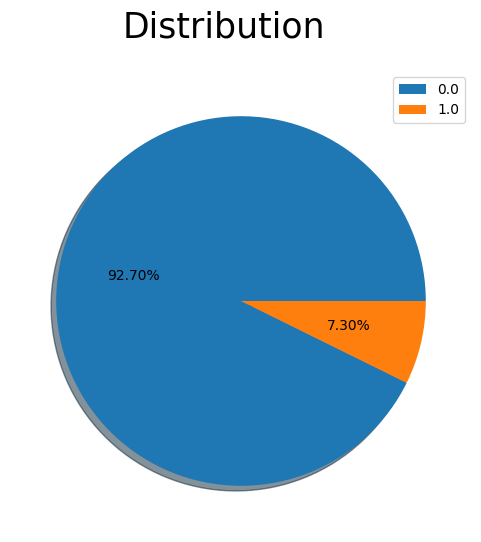

In [ ]:
fig_y_eval = categorical_distribution(y_eval, 'TARGET')

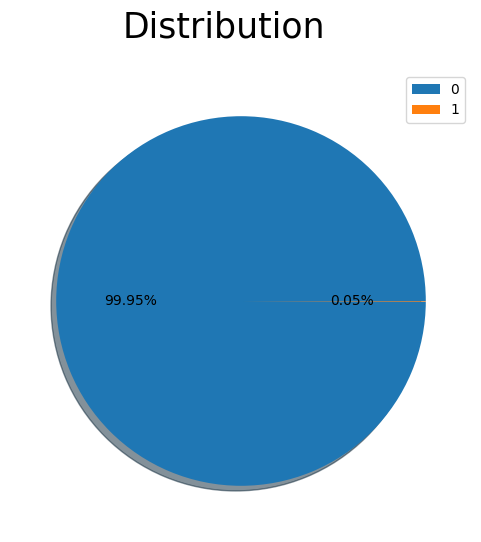

In [ ]:
y_predict = xgboost_grid_search.predict(X_eval_imputed)
fig_y_predict = categorical_distribution(pd.Series(y_predict), 'TARGET')

## Déploiement d'un modèle sklearn avec MLflow

### Présentation de MLflow

> MLflow is a platform to streamline machine learning development, including tracking experiments, packaging code into reproducible runs, and sharing and **deploying models**. MLflow offers a set of lightweight APIs that can be used with any existing machine learning application or library (TensorFlow, PyTorch, XGBoost, etc), wherever you currently run ML code (e.g. in notebooks, standalone applications or the cloud). MLflow's current components are:
>- MLflow Tracking: An API to log parameters, code, and results in machine learning experiments and compare them using an interactive UI.
>- MLflow Projects: A code packaging format for reproducible runs using Conda and Docker, so you can share your ML code with others.
>- **MLflow Models: A model packaging format and tools that let you easily deploy the same model (from any ML library) to batch and real-time scoring on platforms >such as Docker, Apache Spark, Azure ML and AWS SageMaker.**
>- MLflow Model Registry: A centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of MLflow Models.

[Source](https://github.com/mlflow/mlflow)

--------

MLflow est une librairie dédiée à la gestion du cycle de vie d'un projet de machine learning, à savoir :
- le suivi des résultats liés aux expériences (MLflow Tracking)
- garantir la reproducibilité des expériences et le partage de code (MLflow Projects)
- la gestion des modèles sous un format normalisé afin de simplifier les déploiements locaux ou cloud (MLflow Models)
- la centralisation et le versionnage les modèles (MLflow Model Registry)

**On s'intéresse dans le cadre de l'exercice à MLflow Models uniquement**, vous pouvez explorer les autres fonctionnalités bien entendu, cependant ce n'est pas l'objectif de cet exercice.

-------

### Format de stockage d'un modèle

Un modèle MLflow est un répertoire contenant une liste de fichiers, dont un nommé MLmodel qui liste les différentes flavors (terme MLflow) dans lesquelles le modèle est utilisable.

Les flavors sont une façon pratique de définir comment exécuter un modèle, cette convention facilite le déploiement car la flavor standardise la façon de prédire à partir d'un modèle. MLflow définit par exemple des flavors pour une fonction python, sklearn, tensorflow, xgboost.

Dans le répertoire de sauvegarde du modèle MLflow, le fichier MLmodel contient l'ensemble des flavors disponibles, par exemple :
```yaml
time_created: 2018-05-25T17:28:53.35

flavors:
  sklearn:
    sklearn_version: 0.19.1
    pickled_model: model.pkl
  python_function:
    loader_module: mlflow.sklearn
```

Tous les outils supportant les flavors `python_function` ou `sklearn` pourront utiliser ce modèle, par exemple pour un déploiement avec la commande suivante.

```python
mlflow models serve -m my_model
```

D'autres outils cloud comme AWS SageMaker ou Azure ML peuvent utiliser ces flavors.

[Documentation pour approfondir](https://mlflow.org/docs/latest/models.html#storage-format)

-----------

### Signature d'un modèle

Afin de garantir que les données d'entrée d'un modèle sont conformes à ce qui est attendu, les modèles MLflow peuvent inclure des metadatas décrivant les entrées et sorties :
- Model Signature - description des entrées et sorties du modèle
- Model Input Example - exemple d'une entrée valide

La signature du modèle permet de renseigner le nom des colonnes et leurs types afin de vérifier si ils sont similaires lors de la prédiction.

[Documentation](https://mlflow.org/docs/latest/models.html#model-signature-and-input-example)

In [40]:
from mlflow.models.signature import infer_signature

<img src='./images/logo_oc.png' width=15px />  Utiliser la fonction `infer_signature` afin d'extraire la signature à partir des données d'entrée et de sortie.

In [41]:
signature = infer_signature(X_train_balanced, y_train_balanced)

------

### Sauvegarde du modèle sklearn

In [42]:
import mlflow.sklearn

<img src='./images/logo_oc.png' width=15px />  Sauvegarder le pipeline à l'aide de la fonction [save_model](https://mlflow.org/docs/latest/python_api/mlflow.sklearn.html#mlflow.sklearn.save_model) en n'oubliant pas de préciser la signature.

In [43]:
best_model = dt_grid_search.best_estimator_

In [44]:
pipeline = best_model

In [46]:
mlflow.sklearn.save_model(pipeline, 'mlflow_model1', signature=signature)